# 1. libraries import


In [ ]:
# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from scipy import stats

# Modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, f1_score, recall_score, precision_recall_curve
)
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

from imblearn.over_sampling import SMOTE

# set random number
np.random.seed(42)

# visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

! pip install ucimlrepo
! pip install category_encoders

from ucimlrepo import fetch_ucirepo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.8 MB/s eta 0:00:00


# 2. data preprossing

In [ ]:
data = fetch_ucirepo(id=296)
X = data.data.features
y = data.data.targets

/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


#### 2-1. Convert readmitted into a binary variable

In [ ]:
# positive class (1)： <30
# negative class (0)： NO or >30

y = y['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})

# Combine features and target
df = pd.concat([X, y], axis=1)
print(f"Original data shape: {df.shape}")

Original data shape: (101766, 48)


/tmp/ipython-input-1702060874.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})


#### 2-2. Missing value and redundancy handling

In [ ]:
df = df.drop(columns=['weight', 'payer_code'])

df['medical_specialty'] = df['medical_specialty'].fillna('Other')
df['race'] = df['race'].fillna('Other')


diag_cols = ['diag_1', 'diag_2', 'diag_3']
df = df.dropna(subset=diag_cols)

#### 2-3. ICD-9 grouping mapping

In [ ]:
def map_icd9(code):
    if pd.isna(code):
        return 'Other'
    code = str(code).strip()
    if code.startswith('V'):
        return 'Other'
    elif code.startswith('E'):
        return 'Injury'
    try:
        code_num = float(code)
    except ValueError:
        return 'Other'
    if 1 <= code_num <= 139:
        return 'Infectious'
    elif 140 <= code_num <= 239:
        return 'Neoplasms'
    elif 240 <= code_num <= 279:
        return 'Endocrine'
    elif 280 <= code_num <= 289:
        return 'Blood'
    elif 290 <= code_num <= 319:
        return 'Mental'
    elif 320 <= code_num <= 389:
        return 'Nervous'
    elif 390 <= code_num <= 459:
        return 'Circulatory'
    elif 460 <= code_num <= 519:
        return 'Respiratory'
    elif 520 <= code_num <= 579:
        return 'Digestive'
    elif 580 <= code_num <= 629:
        return 'Genitourinary'
    elif 630 <= code_num <= 679:
        return 'Pregnancy'
    elif 680 <= code_num <= 709:
        return 'Skin'
    elif 710 <= code_num <= 739:
        return 'Musculoskeletal'
    elif 740 <= code_num <= 759:
        return 'Congenital'
    elif 760 <= code_num <= 779:
        return 'Perinatal'
    elif 780 <= code_num <= 799:
        return 'Symptoms'
    elif 800 <= code_num <= 999:
        return 'Injury'
    else:
        return 'Other'

for col in diag_cols:
    df[col] = df[col].apply(map_icd9)

#### 2-4. Numerical feature scaling

In [ ]:
numeric_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

#### 2-5. One-Hot Encoding for Categorical variable

In [ ]:
categorical_cols_final = [
    'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'medical_specialty', 'max_glu_serum', 'A1Cresult',
    'change', 'diabetesMed',
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone',
    'diag_1', 'diag_2', 'diag_3'
]

data_final = pd.get_dummies(df, columns=categorical_cols_final, drop_first=True)

#### 2-6. Final cleaning and preparation

In [ ]:
X = data_final.drop(columns=['readmitted'])
y = data_final['readmitted']
print("\n--- Preprocessing Summary ---")
print(f"Final number of features: {X.shape[1]}")
print(f"Final DataFrame shape for modeling: {data_final.shape}")
print(f"Target variable distribution:\n{y.value_counts()}")


--- Preprocessing Summary ---
Final number of features: 245
Final DataFrame shape for modeling: (100244, 246)
Target variable distribution:
readmitted
0    88994
1    11250
Name: count, dtype: int64


# 3. Modelling

Training set: (80195, 245), Test set: (20049, 245)
Training set class distribution:
readmitted
0    71195
1     9000
Name: count, dtype: int64
Class distribution after downsampling:
readmitted
0    9000
1    9000
Name: count, dtype: int64

🚀 Training DecisionTree with GridSearchCV
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 DecisionTree Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

  No Readmit       0.92      0.74      0.82     17799
    <30 Days       0.19      0.48      0.27      2250

    accuracy                           0.71     20049
   macro avg       0.55      0.61      0.54     20049
weighted avg       0.84      0.71      0.76     20049

 Optimal threshold: 0.550
AUC: 0.6326, F1 (default/optimized): 0.2609/0.2676, Recall (default/optimized): 0.5431/0.4769


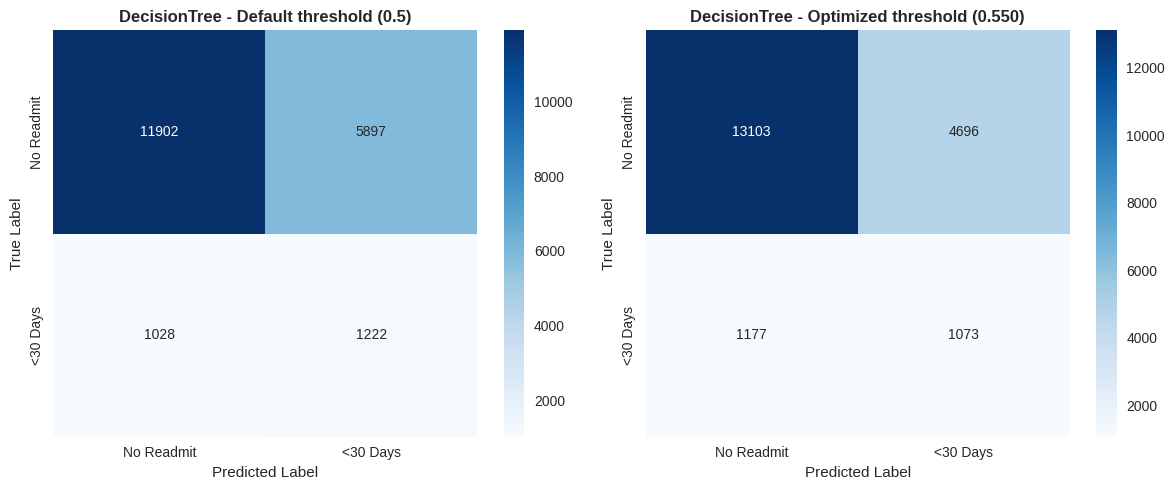

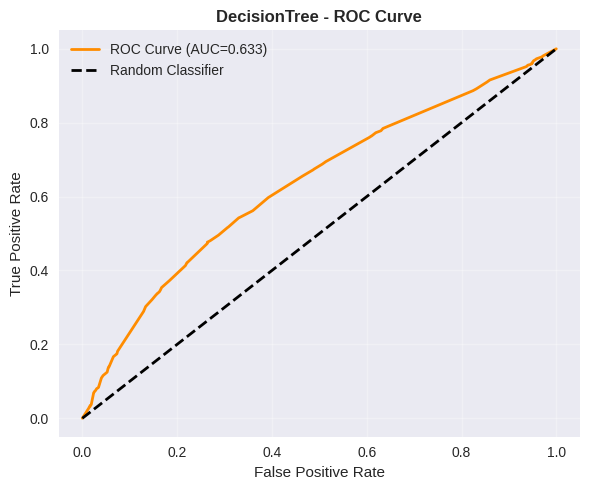


🚀 Training RandomForest with GridSearchCV
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 RandomForest Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

  No Readmit       0.92      0.81      0.86     17799
    <30 Days       0.21      0.41      0.28      2250

    accuracy                           0.77     20049
   macro avg       0.56      0.61      0.57     20049
weighted avg       0.84      0.77      0.80     20049

 Optimal threshold: 0.539
AUC: 0.6733, F1 (default/optimized): 0.2748/0.2810, Recall (default/optimized): 0.6062/0.4076


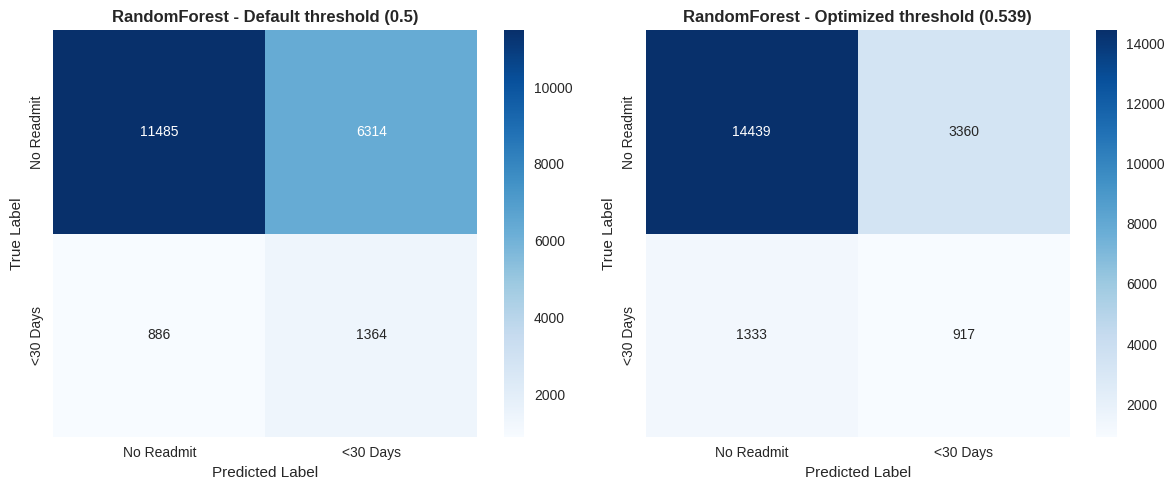

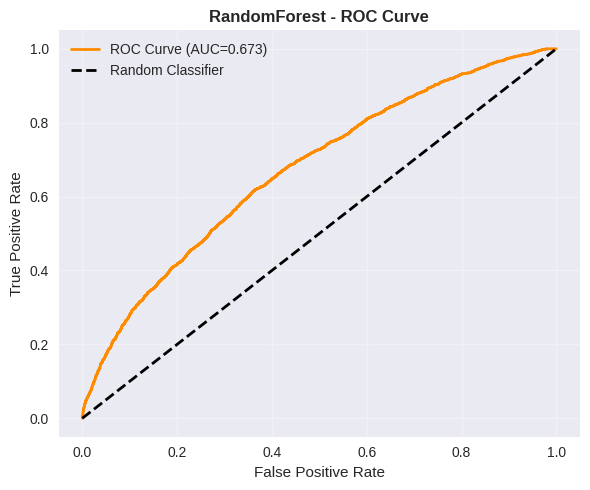


🚀 Training XGBoost with GridSearchCV
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:25:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 XGBoost Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
              precision    recall  f1-score   support

  No Readmit       0.92      0.78      0.84     17799
    <30 Days       0.21      0.47      0.29      2250

    accuracy                           0.74     20049
   macro avg       0.57      0.62      0.57     20049
weighted avg       0.84      0.74      0.78     20049

 Optimal threshold: 0.556
AUC: 0.6803, F1 (default/optimized): 0.2761/0.2918, Recall (default/optimized): 0.5902/0.4684


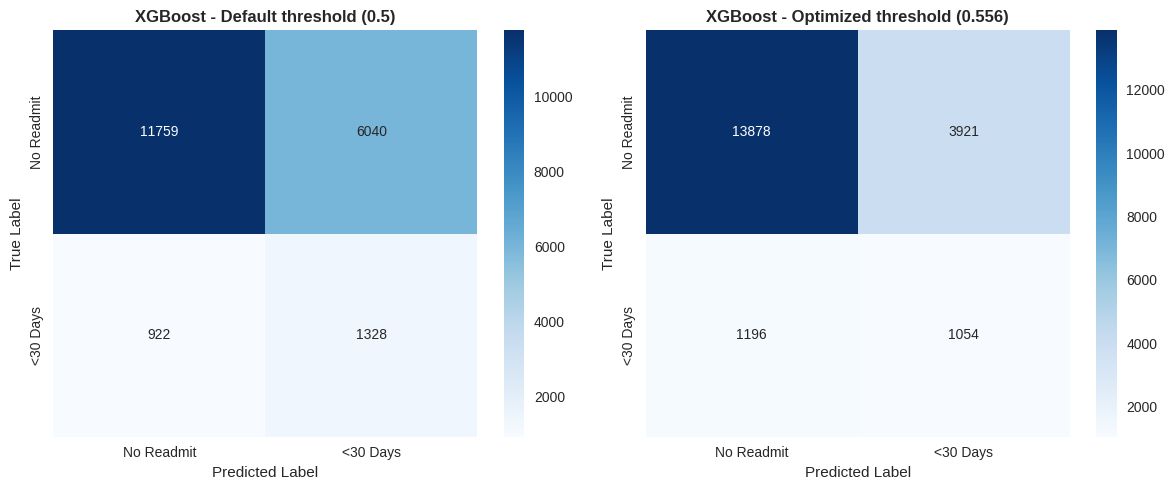

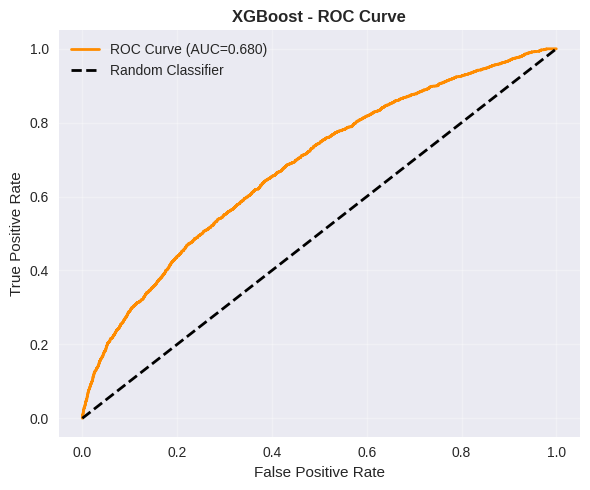


🚀 Training KNN with GridSearchCV
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 KNN Best parameters: {'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

  No Readmit       0.91      0.77      0.83     17799
    <30 Days       0.18      0.39      0.24      2250

    accuracy                           0.73     20049
   macro avg       0.54      0.58      0.54     20049
weighted avg       0.83      0.73      0.77     20049

 Optimal threshold: 0.599
AUC: 0.6105, F1 (default/optimized): 0.2341/0.2432, Recall (default/optimized): 0.5427/0.3933


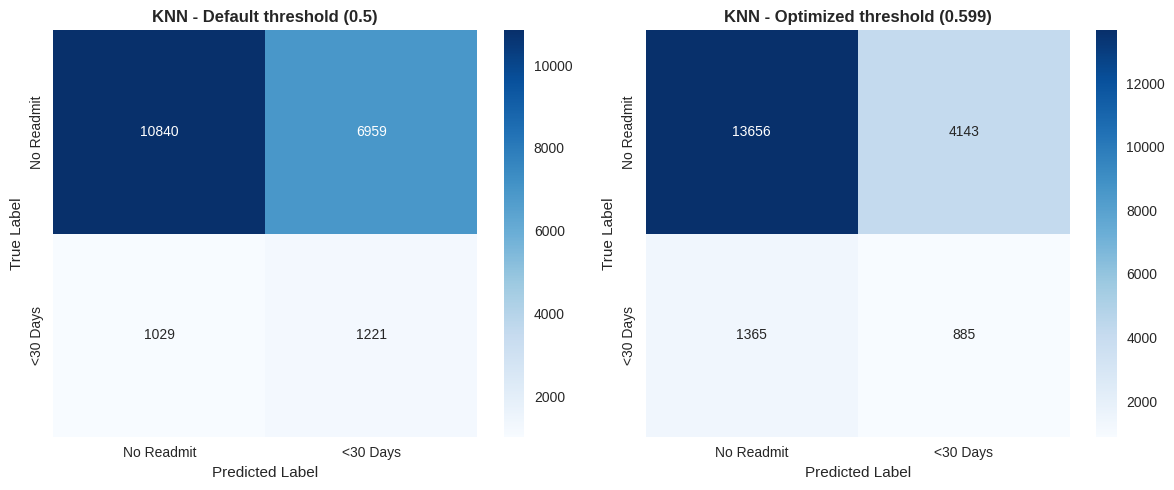

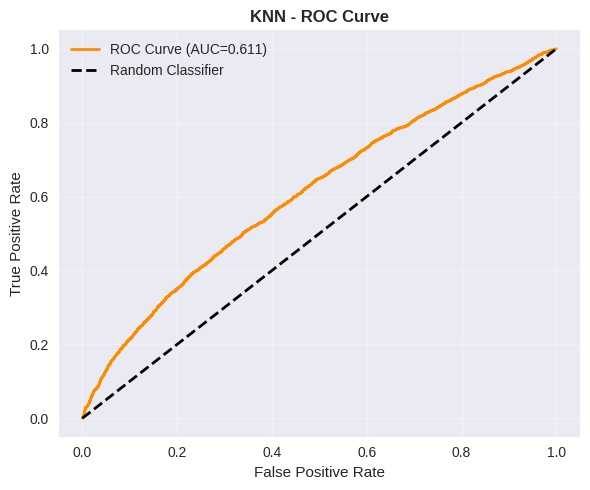


🚀 Training LogisticRegression with GridSearchCV
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 LogisticRegression Best parameters: {'C': 1, 'solver': 'liblinear'}
              precision    recall  f1-score   support

  No Readmit       0.93      0.68      0.78     17799
    <30 Days       0.18      0.57      0.27      2250

    accuracy                           0.66     20049
   macro avg       0.55      0.62      0.53     20049
weighted avg       0.84      0.66      0.72     20049

 Optimal threshold: 0.502
AUC: 0.6680, F1 (default/optimized): 0.2730/0.2742, Recall (default/optimized): 0.5724/0.5667


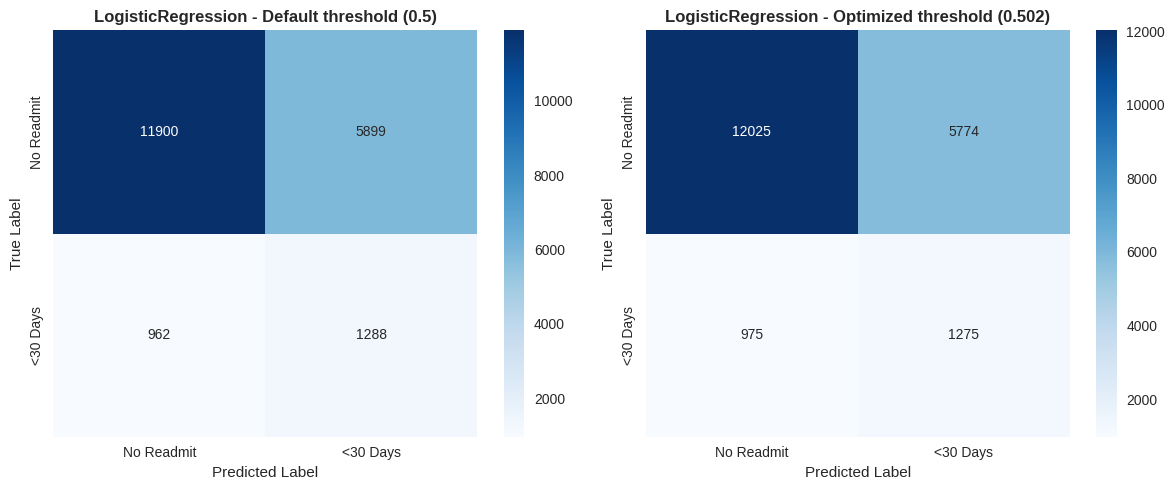

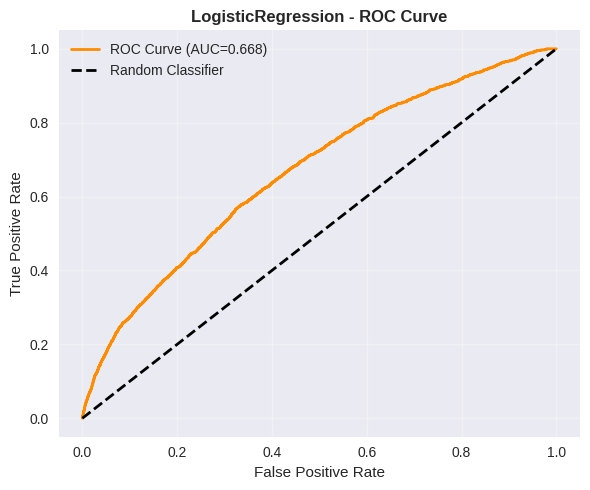


=== Model Performance Summary ===
                       AUC  F1 (Optimized)  Recall (Optimized)    Time
Model                                                                 
DecisionTree        0.6326          0.2676              0.4769  0.1170
RandomForest        0.6733          0.2810              0.4076  0.2612
XGBoost             0.6803          0.2918              0.4684  0.1852
KNN                 0.6105          0.2432              0.3933  0.1463
LogisticRegression  0.6680          0.2742              0.5667  0.1157


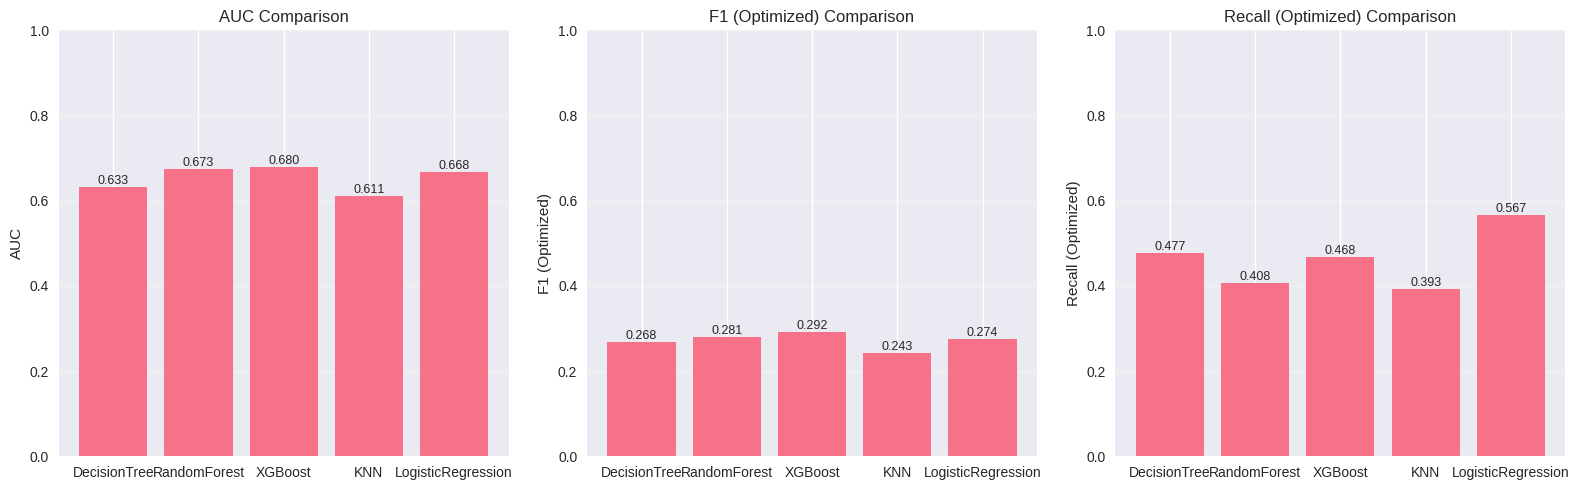

/tmp/ipython-input-2297353449.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


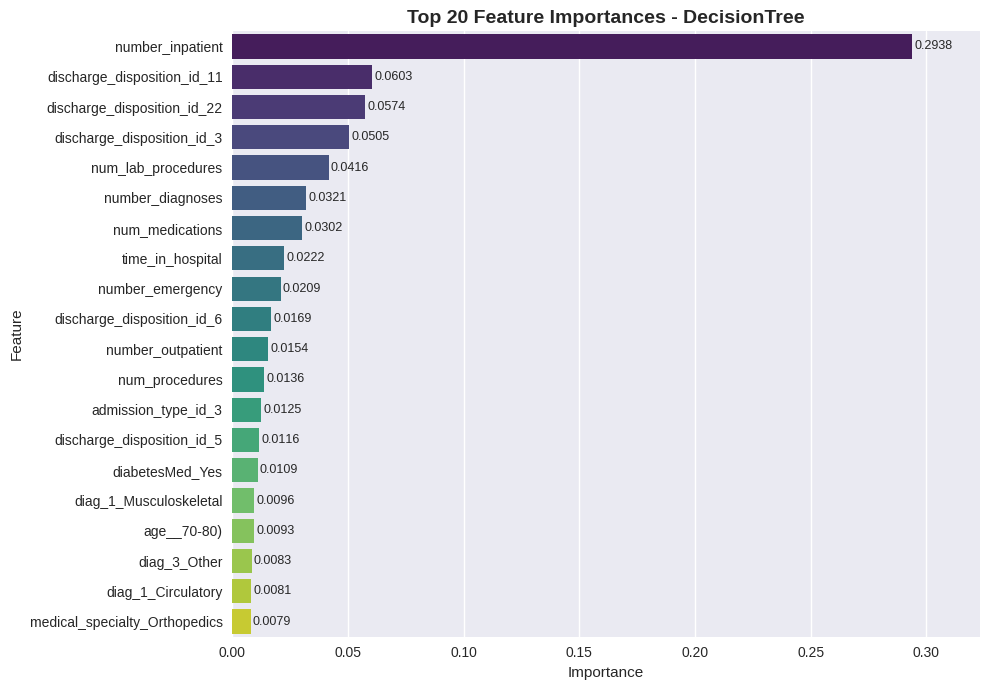

/tmp/ipython-input-2297353449.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


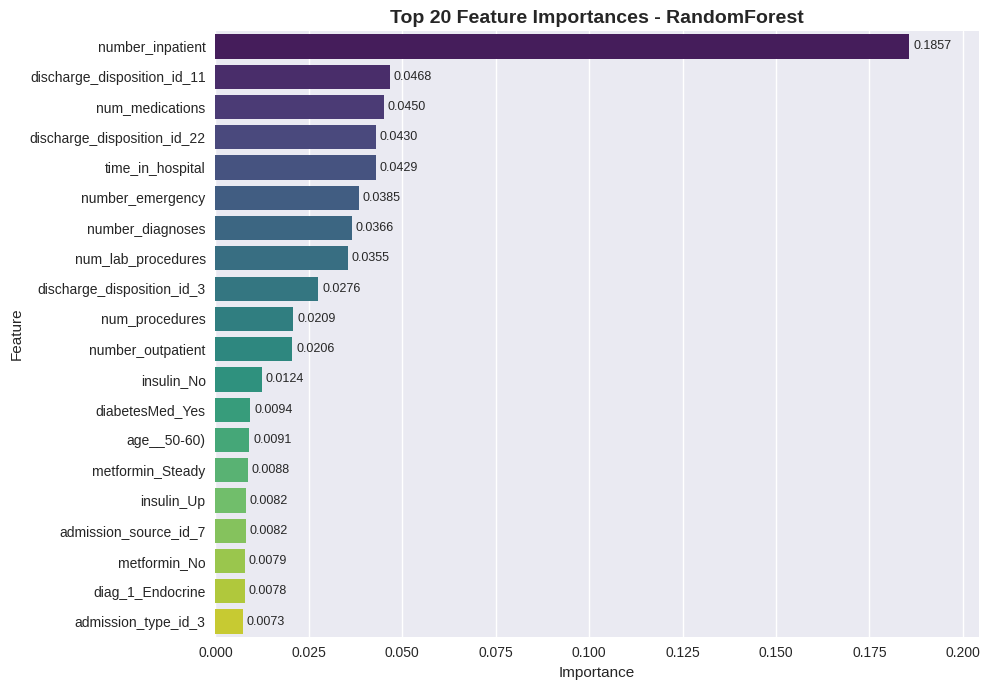

/tmp/ipython-input-2297353449.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


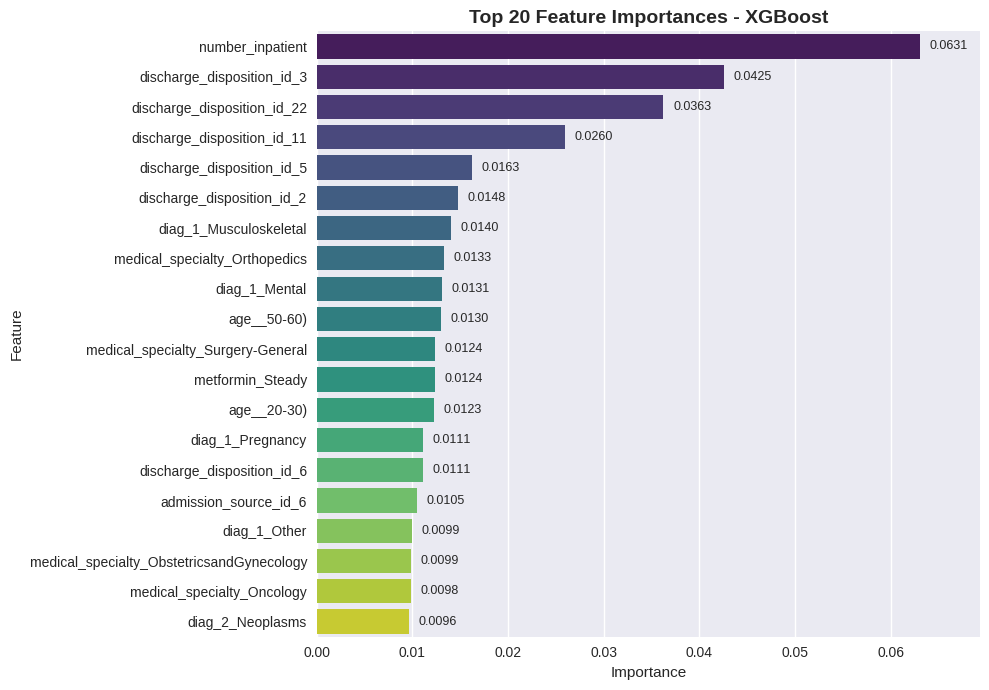

 KNN does not support feature importance extraction, skipped.


/tmp/ipython-input-2297353449.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


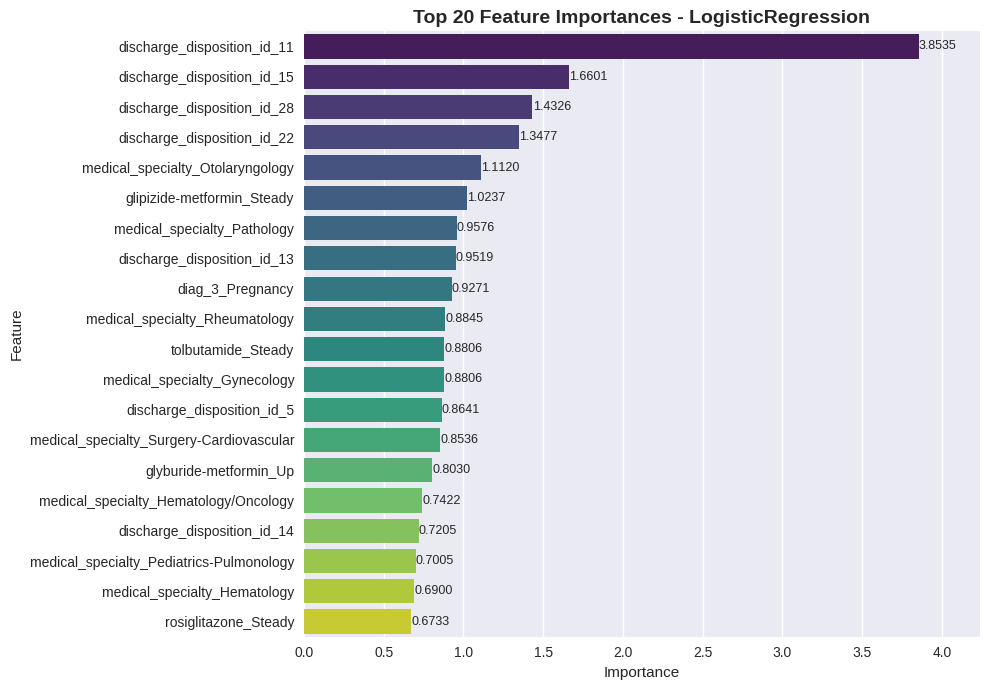

In [ ]:
# 1. Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Training set class distribution:\n{y_train.value_counts()}")


# 2. Downsample majority class
train_data = pd.concat([X_train, y_train], axis=1)
majority = train_data[train_data['readmitted']==0]
minority = train_data[train_data['readmitted']==1]

majority_downsampled = majority.sample(n=len(minority), random_state=42)
train_balanced = pd.concat([majority_downsampled, minority], axis=0).sample(frac=1, random_state=42)

X_train_balanced = train_balanced.drop('readmitted', axis=1)
y_train_balanced = train_balanced['readmitted']
print(f"Class distribution after downsampling:\n{y_train_balanced.value_counts()}")

# 3. Clean feature names function (XGBoost compatible)
def clean_feature_names(df):
    forbidden_chars = ['[', ']', '<', ',']
    col_mapping = {col: col.replace('[','_').replace(']','_').replace('<','_').replace(',','_') for col in df.columns}
    return df.rename(columns=col_mapping)

X_train_balanced = clean_feature_names(X_train_balanced)
X_test = clean_feature_names(X_test)

# 4. Model and hyperparameter settings
neg_count = y_train_balanced.value_counts().get(0, 1)
pos_count = y_train_balanced.value_counts().get(1, 1)
scale_pos_weight_value = neg_count / pos_count

param_grids = {
    'DecisionTree': {'max_depth':[10,20],'min_samples_split':[2],'min_samples_leaf':[1]},
    'RandomForest': {'n_estimators':[100,200],'max_depth':[10],'min_samples_split':[2],'min_samples_leaf':[1]},
    'XGBoost': {'n_estimators':[100,200],'max_depth':[5],'learning_rate':[0.1],'subsample':[1.0],'colsample_bytree':[1.0]},
    'KNN': {'n_neighbors':[5,10],'weights':['distance']},
    'LogisticRegression': {'C':[0.01,0.1,1,10],'solver':['liblinear']}
}

models = {
    'DecisionTree': {'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'), 'params': param_grids['DecisionTree']},
    'RandomForest': {'model': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1), 'params': param_grids['RandomForest']},
    'XGBoost': {'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight_value, n_jobs=-1), 'params': param_grids['XGBoost']},
    'KNN': {'model': KNeighborsClassifier(n_jobs=-1), 'params': param_grids['KNN']},
    'LogisticRegression': {'model': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'), 'params': param_grids['LogisticRegression']}
}

# 5. Model training, threshold optimization, and evaluation
results = {}
total_start_time = time.time()

for name, m in models.items():
    print(f"\n{'='*60}")
    print(f"🚀 Training {name} with GridSearchCV")
    print(f"{'='*60}")

    grid = GridSearchCV(estimator=m['model'], param_grid=m['params'], cv=5, scoring='f1', n_jobs=-1, verbose=2)
    model_start_time = time.time()
    grid.fit(X_train_balanced, y_train_balanced)
    model_elapsed = (time.time() - model_start_time) / 60

    best_model = grid.best_estimator_

    # Predictions
    y_pred_proba = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else best_model.decision_function(X_test)
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]

    y_pred_default = (y_pred_proba >= 0.5).astype(int)
    y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1_default = f1_score(y_test, y_pred_default)
    f1_optimized = f1_score(y_test, y_pred_optimized)
    recall_default = recall_score(y_test, y_pred_default)
    recall_optimized = recall_score(y_test, y_pred_optimized)
    precision_default = precision_score(y_test, y_pred_default)
    precision_optimized = precision_score(y_test, y_pred_optimized)

    # Print report
    print(f"\n {name} Best parameters: {grid.best_params_}")
    print(classification_report(y_test, y_pred_optimized, target_names=['No Readmit','<30 Days']))
    print(f" Optimal threshold: {best_threshold:.3f}")
    print(f"AUC: {roc_auc:.4f}, F1 (default/optimized): {f1_default:.4f}/{f1_optimized:.4f}, Recall (default/optimized): {recall_default:.4f}/{recall_optimized:.4f}")

    # Confusion matrix visualization
    fig, axes = plt.subplots(1,2,figsize=(12,5))
    for idx, (cm, title) in enumerate([
        (confusion_matrix(y_test, y_pred_default), f'{name} - Default threshold (0.5)'),
        (confusion_matrix(y_test, y_pred_optimized), f'{name} - Optimized threshold ({best_threshold:.3f})')
    ]):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=['No Readmit','<30 Days'], yticklabels=['No Readmit','<30 Days'])
        axes[idx].set_title(title, fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicted Label'); axes[idx].set_ylabel('True Label')
    plt.tight_layout(); plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC={roc_auc:.3f})')
    plt.plot([0,1],[0,1],'k--', lw=2, label='Random Classifier')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC Curve', fontsize=12, fontweight='bold')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    results[name] = {
        'model': best_model,
        'best_params': grid.best_params_,
        'best_threshold': best_threshold,
        'roc_auc': roc_auc,
        'f1_score_default': f1_default,
        'f1_score_optimized': f1_optimized,
        'recall_default': recall_default,
        'recall_optimized': recall_optimized,
        'precision_default': precision_default,
        'precision_optimized': precision_optimized,
        'training_time': model_elapsed
    }

total_elapsed = (time.time() - total_start_time)/60

# 6. Model performance summary visualization
summary_data = []
for name, res in results.items():
    summary_data.append([
        name, res['roc_auc'], res['f1_score_optimized'], res['recall_optimized'], res['training_time']
    ])
summary_df = pd.DataFrame(summary_data, columns=['Model','AUC','F1 (Optimized)','Recall (Optimized)','Time']).set_index('Model')
summary_df = summary_df.round(4)
print("\n=== Model Performance Summary ===")
print(summary_df)

# Visualization
fig, axes = plt.subplots(1,3,figsize=(16,5))
metrics = [('AUC','AUC'),('F1 (Optimized)','F1 (Optimized)'),('Recall (Optimized)','Recall (Optimized)')]
for idx,(col,title) in enumerate(metrics):
    ax = axes[idx]
    values = summary_df[col].values
    models_names = summary_df.index.tolist()
    bars = ax.bar(models_names, values)
    ax.set_ylabel(title); ax.set_title(f'{title} Comparison'); ax.set_ylim([0,1]); ax.grid(axis='y',alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout(); plt.show()

# 7. Feature importance visualization (All Models, Top 20)
top_n = 20
for model_name, res in results.items():
    best_model = res['model']
    feature_names = X_train_balanced.columns

    # Try to extract importance
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importances = np.abs(best_model.coef_[0])
    else:
        print(f" {model_name} does not support feature importance extraction, skipped.")
        continue

    # Prepare dataframe
    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(top_n)

    # Visualization
    plt.figure(figsize=(10, 7))
    bars = sns.barplot(
        x='importance', y='feature',
        data=feat_imp_df, orient='h',
        palette='viridis'
    )
    plt.title(f'Top {top_n} Feature Importances - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.xlim([0, feat_imp_df['importance'].max() * 1.1])

    # Add value annotations
    for bar in bars.patches:
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                 f'{width:.4f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()
